### Imports

In [1]:

import networkx as nx
import numpy as np
import random, math
import graphviz
import functools, collections, operator

from scipy.stats import shapiro
import scipy.stats as scs

import plotly.figure_factory as ff

from scipy.stats import norm
import scipy.stats as stats

import os
import time

import pylab

from statsmodels.graphics.gofplots import qqplot

#import kaleido

import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import plotly.graph_objects as go
from pyvis.network import Network
from networkx.drawing.nx_agraph import graphviz_layout
import plotly.express as px
from plotly._subplots import make_subplots
import plotly


# import models
from classes.jackson_model import JacksonSimulationV2
from classes.network_drawing import plotly_sim_drawing, plotly_lines


### Showcases

In [12]:

# showcases
showcase_sim_no_bias = JacksonSimulationV2(0, 100, 10, 1, 10, 1, 0.5, biased=False, rho=1, epsilon=1)
showcase_sim_expo = JacksonSimulationV2(0, 100, 10, 1, 10, 1, 0.5, biased=True, rho=1, epsilon=1.75)
showcase_sim_fb = JacksonSimulationV2(0, 100, 10, 1, 10, 1, 0.5, biased=True, rho=1.75, epsilon=1)
showcase_sim_expo_fb = JacksonSimulationV2(0, 100, 10, 1, 10, 1, 0.5, biased=True, rho=1.5, epsilon=1.5)

showcase_sims = [showcase_sim_no_bias, showcase_sim_expo, showcase_sim_fb, showcase_sim_expo_fb]

showcase_plots = [plotly_sim_drawing.plotly_draw(plotly_sim_drawing(), showcase_sim, layout='spring', draw_largest_CC=True, title=None) for showcase_sim in showcase_sims]





In [20]:

showcase_plots[0]


### Rho and Epsilon distributions

In [3]:

df_rhoeps = pd.read_csv('EpsRhoCalcs.csv')[['county', 'county_name', 'exposure_grp_mem_county', 'exposure_grp_mem_high_county', 'bias_grp_mem_county', 'bias_grp_mem_high_county', 'Epsilon', 'EpsilonHigh', 'Rho', 'RhoHigh']].dropna()

df_rhoeps = df_rhoeps.apply(pd.to_numeric, errors='ignore')


In [29]:

# Assume df is your Pandas DataFrame and column_name is the column you want to test


# import the data, convert
df_rhoeps = pd.read_csv('EpsRhoCalcs.csv')[['county', 'county_name', 'exposure_grp_mem_county', 'exposure_grp_mem_high_county', 'bias_grp_mem_county', 'bias_grp_mem_high_county', 'Epsilon', 'EpsilonHigh', 'Rho', 'RhoHigh']].dropna()
df_rhoeps = df_rhoeps.apply(pd.to_numeric, errors='ignore')
df_rhoeps["EpsilonColor"] = np.where(df_rhoeps["Epsilon"]<1, 'red', 'blue')
df_rhoeps["RhoColor"] = np.where(df_rhoeps["Rho"]<1, 'red', 'blue')


vars = ['Epsilon', 'Rho']# 'EpsilonHigh', 'Rho', 'RhoHigh']
figs = []

for var in vars:
    # Winsorize at the 0.5% level
    df_rhoeps = df_rhoeps[(df_rhoeps[var] <= df_rhoeps[var].quantile(0.995)) & df_rhoeps[var] >= df_rhoeps[var].quantile(0.005)]

    #calculate mean and variance
    mu, std = norm.fit(df_rhoeps[var])

    # Shapiro Wilk test (want p<0.05)
    stat, p = shapiro(df_rhoeps[var])

    # count share below 1
    below_one_share = len([x for x in list(df_rhoeps[var]) if x < 1]) / len(list(df_rhoeps[var]))

    fig_title = f'{var} density plot<br>Winsorised at 0.5% level<br>Normal distribution: mean={round(mu,3)}, se={round(std, 3)}<br>Shapiro-Wilk stat and prob: {format(stat, ".3f")}, {"{:.1e}".format(p)}<br>Prob <1: {round(below_one_share, 3)}'

    # Create a histogram of the column
    fig = px.histogram(df_rhoeps, x=var, nbins=100, opacity=0.9, marginal=None, histnorm='probability density', title=fig_title, width=600, height=600)#, color=df_rhoeps[var + 'Color'])

    # Add a normal distribution curve to the histogram
    x_axis = np.linspace(df_rhoeps[var].min(), df_rhoeps[var].max(), 100)
    y_axis = norm.pdf(x_axis, mu, std)
    curve = go.Scatter(x=x_axis, y=y_axis, mode='lines', line=dict(width=2, color='black'), name=f'Normal Distribution: ', showlegend=False)
    fig.add_trace(curve)

    figs.append(fig)

for var in vars:
    stat, p = shapiro(df_rhoeps[var])
    print(f'{var} has a SW stat of {format(stat, ".3f")} with p-value {"{:.1e}".format(p)}')


figs[1]



Epsilon has a SW stat of 0.901 with p-value 2.6e-40
Rho has a SW stat of 0.992 with p-value 5.1e-12


In [32]:

df_rhoeps['Epsilon'].skew()


1.3360960560481974

## General social network characteristics

Need to test: 

* Short APL (order of log(n))
* Larger clustering coefs than random
* Fat degree tails
* Positive assortativity
* Negative clustering-neighbour-degree correlation




In [10]:

n_sims = 1


val_dict = {'APL': [], 'Clustering': [], 'Assortativity': [], 'Degree-neighbour-clustering': [], 'Degree-list': []}

for i in range(n_sims):
    sim = JacksonSimulationV2(0, 100, 5, 1, 5, 1, 0.5, False, 1)
    graph = sim.graph_history[-1]
    return_dict = sim.helper_functions().graph_social_network_chars(graph, summarise=False)

    for key in list(val_dict.keys()):
        val_dict[key].append(return_dict[key])


degree_list = list(np.concatenate(val_dict['Degree-list']))
del val_dict['Degree-list']

val_df = pd.DataFrame(val_dict)


Seems to work alright: positive CND correlation probably driven by relativley low clustering overall, consistent with their findings for small number of nodes.

## Old stuff

### Rho effect on HSES assortativity

In [23]:

# initial nodes and time
initial_n = 0
T = 100

p = 0.25

# parent nodes and prob
m = 4
pm_o = p

# parent neighbours and prob
n = 16
pn_o = p

rho = 3

# p high SES
p_SES_high = 0.5

rho_list = np.arange(0.5, 5, 0.05)
rho_list = [rho_val for rho_val in rho_list]
test_sims = [JacksonSimulationV2(initial_n, T, m, pm_o, n, pn_o, p_SES_high, biased=True, rho=rho_val) for rho_val in rho_list]


SES_assortativity_list = [nx.assortativity.attribute_assortativity_coefficient(sim.graph_history[-1], 'SES_High') for sim in test_sims]


#plt.plot(rho_list, SES_assortativity_list)






In [29]:

param_dict = {
    'xaxis_title': 'Rho', 
    'yaxis_title': 'SES Assortativity',
    'showlegend': False, 
    'xaxis_range': [0.5,5],
    'yaxis_range': [-1,1]
    }

plotly_lines().line_graph(x_vals=rho_list,y_vals=SES_assortativity_list, param_dict=param_dict, colors = ["rgb(250, 20, 20)"], hline_y = 0, hline_text = '', vline_x = 1, vline_text = 'No friending bias')


In [3]:

df_rho_SES_ass = pd.DataFrame(np.transpose([rho_list, SES_assortativity_list]), columns=['Rho', 'SES Assortativity'])

rho_ass = px.line(df_rho_SES_ass, x='Rho', y='SES Assortativity')

rho_ass.update_layout(
    title = None, 
    font=dict(size = 18),
    xaxis_title = 'Rho', 
    yaxis_title = 'SES Assortativity',
    width = 500, height = 500,
    showlegend = True, 
    legend=dict(x=0.75,y=1),
    legend_title_text = '',
    xaxis_range = [0,5],
    yaxis_range = [-1,1],
    margin=dict(b=5,l=5,r=5,t=5),
    xaxis = dict(showgrid = False, showline = True, linecolor = 'rgb(0,0,0)', linewidth = 2), 
    yaxis = dict(showgrid = False, showline = True, linecolor = 'rgb(0,0,0)', linewidth = 2),
    plot_bgcolor='rgba(0,0,0,0)')

rho_ass.data[0].line.color = "rgb(250, 20, 250)"
rho_ass.add_hline(y=0, line_width=1, annotation_text = 'Equal share')
rho_ass.add_vline(x=1, line_width=1, annotation_text = 'rho=1: no bias')


### Rho effect on share HSES

In [282]:

# initial nodes and time
initial_n = 0
T = 100

p = 0.25

# parent nodes and prob
m = 4
pm_o = p

# parent neighbours and prob
n = 16
pn_o = p

rho = 3

# p high SES
p_SES_high = 0.5

# run several simulations
rho_list = np.arange(0.25, 5, 0.05)
n_per_rho = 10

test_sims = [[JacksonSimulationV2(initial_n, T, m, pm_o, n, pn_o, p_SES_high, biased=True, rho=rho_val) for i in range(n_per_rho)] for rho_val in rho_list]





In [283]:

# 
H_shares = [np.transpose([new_sim.helper_functions().average_neighbour_type_per_SES(test_sims[i][j].graph_history[-1]) for j in range(n_per_rho)]) for i in range(len(rho_list))]
avg_H_shares = np.transpose(np.average(H_shares, axis=2))
df_avg_H_shares = pd.DataFrame(np.transpose(avg_H_shares), columns=['High SES', 'Low SES'])
df_avg_H_shares['Rho_val'] = rho_list

rho_lines = px.line(df_avg_H_shares, x='Rho_val', y=['High SES', 'Low SES'])

rho_lines.update_layout(
    title = None, 
    font=dict(size = 18),
    xaxis_title = 'Rho', 
    yaxis_title = 'Share of HSES friends',
    width = 500, height = 500,
    showlegend = True, 
    legend=dict(x=0.75,y=1),
    legend_title_text = '',
    xaxis_range = [0.025,5],
    yaxis_range = [0,1],
    margin=dict(b=5,l=5,r=5,t=5),
    xaxis = dict(showgrid = False, showline = True, linecolor = 'rgb(0,0,0)', linewidth = 2), 
    yaxis = dict(showgrid = False, showline = True, linecolor = 'rgb(0,0,0)', linewidth = 2),
    plot_bgcolor='rgba(0,0,0,0)')

rho_lines.data[0].line.color = "rgb(200, 20, 0)"
rho_lines.data[1].line.color = "rgb(0, 20, 200)"
rho_lines.add_hline(y=0.5, line_width=1, annotation_text = 'Equal share')
rho_lines.add_vline(x=1, line_width=1, annotation_text = 'rho=1: no bias')

rho_lines



### Varying p

Varying p

c:\Programming\Python\lib\site-packages\networkx\algorithms\assortativity\correlation.py:278: RuntimeWarning:

invalid value encountered in double_scalars



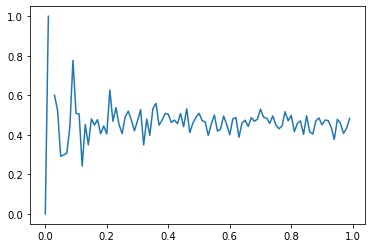

In [152]:

# initial nodes and time
initial_n = 0
T = 100

p = 0.25

# parent nodes and prob
m = 4
pm_o = p

# parent neighbours and prob
n = 16
pn_o = p

rho = 3

# p high SES
p_SES_high = 0.5

p_list = np.arange(0, 1, 0.01)
test_sims = [JacksonSimulationV2(initial_n, T, m, pm_o=p, n=n, pn_o=p, p_SES_high=p_SES_high, biased=True, rho=3) for p in p_list]


SES_assortativity_list = [nx.assortativity.attribute_assortativity_coefficient(sim.graph_history[-1], 'SES_High') for sim in test_sims]


plt.plot(p_list, SES_assortativity_list)


## New stuff

### Epsilon effect on MTO

In [10]:

# general simulation stuff
list_eps_values = np.arange(0.5, 2, 0.5)
print(len(list_eps_values))

#list_rho_values_random = np.random.uniform(0.75, 2, 10)
num_sim_per_rho = 1 # number of simulations with given parameter set
num_MTO_per_sim = 10 # number of simulations on each network
list_sim_stats = []

# simulation parameters

initial_n = 0 # initial nodes
T = 100 # total nodes

p = 0.5 # same-class friend prob
m = 10 # number of parent nodes
pm_o = p
n = 10 # number of parent neighbours
pn_o = p

#epsilon = 1.5 # exposure bias
rho = 1.5 # friending bisa
p_SES_high = 0.5 # share high



# iterate over rho values
for i in range(len(list_eps_values)):

    # create a network and run MTO sims
    for j in range(num_sim_per_rho):
        # create network
        network_sim = JacksonSimulationV2(initial_n, T, m, pm_o, n, pn_o, p_SES_high, biased=True, epsilon = list_eps_values[i], rho=rho)

        # run MTO simulations
        df_MTO_sim = network_sim.MTO_sim_many(network_sim.graph_history[-1], n_sims=num_MTO_per_sim)
        list_sim_stats.append(df_MTO_sim)

        print('\r', f'Finished simulation {j}/{num_sim_per_rho} for rho value {i}/{len(list_eps_values)}', end='')

df_eps = pd.concat(list_sim_stats)
df_eps.sample(5)


3
 Finished simulation 0/1 for rho value 2/3

,sim_id,p_SES_high,epsilon,rho,H_Share,Exposure,Friend_Bias,N_exposure,Degree
7,XfAAubnO,0.5,0.5,1.5,0.750000,1.200000,0.937500,20,8
5,AlKlhkBO,0.5,1.0,1.5,0.400000,1.100000,0.963636,20,10
1,AlKlhkBO,0.5,1.0,1.5,0.333333,0.700000,0.952381,20,6
1,XfAAubnO,0.5,0.5,1.5,0.857143,1.600000,0.946429,20,7
6,XfAAubnO,0.5,0.5,1.5,0.375000,1.333333,0.968750,20,8


In [4]:


df_eps = pd.concat(list_sim_stats)
df_eps.to_csv('eps.csv')
#df_eps = pd.read_csv('test.csv')

df_eps['Predicted_H_Share'] = 1/((1+df_eps['epsilon'])*(df_eps['rho']))
df_eps['Predicted_Exposure'] = 1/(df_eps['p_SES_high']*(1+df_eps['epsilon']))
df_eps['Predicted_Friend_Bias'] = (df_eps['epsilon']*(df_eps['rho']-1))/(df_eps['epsilon']*df_eps['rho']+1)


#df_eps.to_csv('test.csv')
heatmap = px.density_heatmap(x=df_eps['epsilon'], y=df_eps['H_Share'], range_x=[0.5,2], range_y=[0,1])
lines = px.line(x=df_eps['epsilon'], y=df_eps['Predicted_H_Share'], range_x=[0.5,2], range_y=[0,1])

fig = go.Figure(data = heatmap.data + lines.data)
fig.show()



### Rho effect

In [13]:

# general simulation stuff
list_rho_values = np.arange(1, 2, 0.1)

#list_rho_values_random = np.random.uniform(0.75, 2, 10)
num_sim_per_rho = 1 # number of simulations with given parameter set
num_MTO_per_sim = 10 # number of simulations on each network
list_sim_stats = []

# simulation parameters

initial_n = 0 # initial nodes
T = 100 # total nodes

p = 0.5 # same-class friend prob
m = 10 # number of parent nodes
pm_o = p
n = 10 # number of parent neighbours
pn_o = p

epsilon = 1.5 # exposure bias
#rho = 1 # friending bisa
p_SES_high = 0.5 # share high



# iterate over rho values
for i in range(len(list_rho_values)):

    # create a network and run MTO sims
    for j in range(num_sim_per_rho):
        # create network
        network_sim = JacksonSimulationV2(initial_n, T, m, pm_o, n, pn_o, p_SES_high, biased=True, epsilon = epsilon, rho=list_rho_values[i])

        # run MTO simulations
        df_MTO_sim = network_sim.MTO_sim_many(network_sim.graph_history[-1], n_sims=num_MTO_per_sim)
        list_sim_stats.append(df_MTO_sim)

        print('\r', f'Finished simulation {j}/{num_sim_per_rho} for rho value {i}/{len(list_rho_values)}', end='')

df_rho = pd.concat(list_sim_stats)
df_rho.sample(5)


 Finished simulation 0/1 for rho value 9/10

,sim_id,p_SES_high,epsilon,rho,H_Share,Exposure,Friend_Bias,N_exposure,Degree
0,CcdWBcfZ,0.5,1.5,1.5,0.111111,0.555556,0.977778,20,9
0,whNuOciB,0.5,1.5,1.4,0.375000,0.600000,0.937500,20,8
6,FKcTmMjT,0.5,1.5,1.8,0.166667,0.900000,0.981481,20,6
7,dDWRjkIO,0.5,1.5,1.6,0.833333,1.263158,0.930556,20,6
7,CcdWBcfZ,0.5,1.5,1.5,0.166667,0.736842,0.976190,20,6


In [14]:

df_rho = pd.concat(list_sim_stats)
df_rho.to_csv('rho.csv')
#df_rho = pd.read_csv('test.csv')

df_rho['Predicted_H_Share'] = 1/((1+df_rho['epsilon'])*(df_rho['rho']))
df_rho['Predicted_Exposure'] = 1/(df_rho['p_SES_high']*(1+df_rho['epsilon']))
df_rho['Predicted_Friend_Bias'] = (df_rho['epsilon']*(df_rho['rho']-1))/(df_rho['epsilon']*df_rho['rho']+1)


#df_rho.to_csv('test.csv')
heatmap = px.density_heatmap(x=df_rho['rho'], y=df_rho['H_Share'], range_x=[1,2], range_y=[0,1])
lines = px.line(x=df_rho['rho'], y=df_rho['Predicted_H_Share'], range_x=[1,2], range_y=[0,1])

fig = go.Figure(data = heatmap.data + lines.data)
fig.show()



### Both rho and epsilon

In [20]:

# general simulation stuff
list_eps_values = np.arange(0.5, 2, 0.05)
list_rho_values = np.arange(1, 2, 0.05)

#list_rho_values_random = np.random.uniform(0.75, 2, 10)
num_sim_per_rho = 10 # number of simulations with given parameter set
num_MTO_per_sim = 100 # number of simulations on each network
list_sim_stats = []

n_sims = len(list_eps_values) * len(list_rho_values) * num_sim_per_rho * num_MTO_per_sim

# simulation parameters

initial_n = 0 # initial nodes
T = 100 # total nodes

p = 1 # same-class friend prob
m = 10 # number of parent nodes
pm_o = p
n = 10 # number of parent neighbours
pn_o = p

#epsilon = 1.5 # exposure bias
#rho = 1.5 # friending bisa
p_SES_high = 0.5 # share high


total_sims = 0
t0 = time.time()

# iterate over eps values
for i in range(len(list_eps_values)):

    # iterate over rho values
    for j in range(len(list_rho_values)):

        # create a network and run MTO sims
        for k in range(num_sim_per_rho):
            # create network
            network_sim = JacksonSimulationV2(initial_n, T, m, pm_o, n, pn_o, p_SES_high, biased=True, epsilon = list_eps_values[i], rho=list_rho_values[j])

            # run MTO simulations
            df_MTO_sim = network_sim.MTO_sim_many(network_sim.graph_history[-1], n_sims=num_MTO_per_sim)
            list_sim_stats.append(df_MTO_sim)


            print('\r', f'Finished simulation {k}/{num_sim_per_rho} for combination {total_sims}/{len(list_eps_values)*len(list_rho_values)}', end='')
    
        total_sims += 1

delta_t = round((time.time()-t0)/60, 2)

print('\r', f'Finished {n_sims} simulations in {delta_t} minutes, average time: {delta_t/n_sims} min/sim', end='')
df_rho_eps = pd.concat(list_sim_stats)
df_rho_eps.head(5)


 Finished simulation 4/10 for combination 545/600

In [16]:

df_rho_eps.to_csv('eps_rho.csv')
#df_rho_eps = pd.read_csv('test.csv')

df_rho_eps['Predicted_H_Share'] = 1/((1+df_rho_eps['epsilon'])*(df_rho_eps['rho']))
df_rho_eps['Predicted_Exposure'] = 1/(df_rho_eps['p_SES_high']*(1+df_rho_eps['epsilon']))
df_rho_eps['Predicted_Friend_Bias'] = (df_rho_eps['epsilon']*(df_rho_eps['rho']-1))/(df_rho_eps['epsilon']*df_rho_eps['rho']+1)


scatter1 = px.scatter_3d(x=df_rho_eps['epsilon'], y=df_rho_eps['rho'], z=df_rho_eps['Friend_Bias'], opacity=0.25)
scatter1.update_traces(marker_size = 2, marker=dict(color='red'))
scatter2 = px.scatter_3d(x=df_rho_eps['epsilon'], y=df_rho_eps['rho'], z=df_rho_eps['Predicted_Friend_Bias'], opacity=0.25)
scatter2.update_traces(marker_size = 2)

fig = go.Figure(data = scatter1.data + scatter2.data)
fig.show()


In [18]:


px.density_heatmap(x=df_rho['epsilon'], y=df_rho['rho'], z=df_rho['H_Share'], range_x=[1,2], range_y=[0,1])



### Sample rho and epsilon from the distribution, run MTO 100 times per simulation, and vary w_H: this shouild hopefully show how important it is to consider friendingf bias 